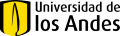

<span style="font-family:Cambria Math">
    
# Micro-proyecto 2. Alcanzando los objetivos de desarrollo sostenible. Un aporte desde el *Machine Learning*

## Contexto:

La ONU estableció la Agenda 2030 con 17 ODS para abordar problemas globales como la pobreza, la educación, la igualdad de género y el impacto ambiental. Organizaciones como el UNFPA analizan información textual para evaluar políticas públicas y su alineación con estos objetivos.


## Problema:

Analizar manualmente grandes volúmenes de texto para identificar su relación con los ODS es costoso y requiere expertos.

## Objetivo:
Desarrollar un modelo basado en PLN y *machine learning* para automatizar esta clasificación y presentar los resultados de manera accesible.
</span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Núñez Campos para entrega el 11 de marzo.**
</div24></span>

***

<span style="font-family:Cambria Math">

## Importación de Librerías

</span>

***

<span style="font-family:Cambria Math">

En primer lugar empezamos con el descargue e importación de las librerias utilizadas en este *notebook*; explicaremos su uso a medida que avancemos en el documento. Creemos importante, tal como se hizo en el primer micro-proyecto, dejar explícitas las versiones usadas para poder replicar este trabajo más adelante.
</span>

In [1]:
#pip install nltk wordcloud spacy langdetect

In [2]:
#!python -m spacy download es_core_news_sm

In [3]:
#pip install googletrans==4.0.0-rc1

In [4]:
# Librerías básicas
import pandas as pd
import numpy as np
from collections import Counter

# Librerías NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
import spacy

# Tratamiento de textos en diferentes idiomas
from langdetect import detect
from googletrans import Translator

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD  # Para LSA

# Visualización
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import matplotlib.cm as cm
%matplotlib inline

In [5]:
# Descarga de palabra vacías
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/p300helios/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Clasificadores y métricas
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [7]:
import warnings # Ignorar las warnings
warnings.filterwarnings("ignore")

In [8]:
from importlib.metadata import version
#Librerias usadas
for library in ['pandas', 'numpy', 'nltk', 'wordcloud', 'scikit-learn', 'spacy','seaborn']:
  print(library, ": ", version(library))

pandas :  2.2.3
numpy :  1.26.4
nltk :  3.9.1
wordcloud :  1.9.4
scikit-learn :  1.6.1
spacy :  3.8.4
seaborn :  0.13.2


In [9]:
# Definición del random state para los algoritmos con pseudo-aleatorios
RANDOM_STATE = 13

***

<span style="font-family:Cambria Math">

## Análisis Exploratorio

Como es usual en el ciclo de ejecución de un proyecto de *Machine Learning* es fundamental hacer un análisis exploratorio que permita identificar inconsistencias en la información, y dar una noción de cómo se distribuyen los datos. A continuación procedemos a obtener algunas gráficas y estadísticas que nos permiten conocer a fondo nuestra información y hacer los ajustes requeridos antes del pre-procesamiento.
</span>

In [10]:
data_raw =  pd.read_excel('sample_data/Train_textosODS.xlsx', sheet_name='Sheet1')
data_raw.head()

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5


In [11]:
data_raw.shape

(9656, 2)

In [12]:
data = data_raw.copy()
data.isna().sum()

textos    0
ODS       0
dtype: int64

In [13]:
data.duplicated().sum()

0

***

<span style="font-family:Cambria Math">

Lo primero que llama la atención es que dentro de nuestro conjunto de entrenamiento solo se encuentran las primeras 16 categorías. Según se conversa con los dueños de la información la categoría 17 es "descartable" porque se trata de una categoría resumen.
</span>

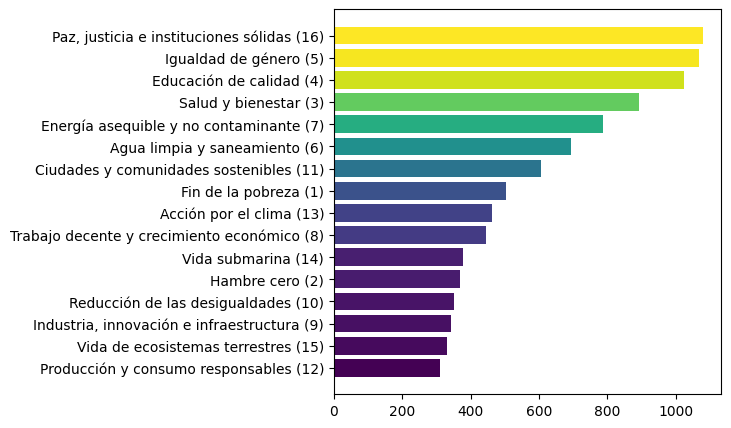

In [14]:
# Nombres de las clases
ods = np.array([
    "Fin de la pobreza", "Hambre cero", "Salud y bienestar", "Educación de calidad", "Igualdad de género",
    "Agua limpia y saneamiento", "Energía asequible y no contaminante", "Trabajo decente y crecimiento económico",
    "Industria, innovación e infraestructura", "Reducción de las desigualdades", "Ciudades y comunidades sostenibles",
    "Producción y consumo responsables", "Acción por el clima", "Vida submarina", "Vida de ecosistemas terrestres",
    "Paz, justicia e instituciones sólidas"
])
counts = data['ODS'].value_counts()
# Plot del número de documentos por categoría
fig, ax = plt.subplots(1, 1, figsize=(5,5))
norm = plt.Normalize(vmin=counts.min(), vmax=counts.max())
colors = cm.viridis(norm(counts))
ax.barh(range(0,16), counts,color=colors)
ax.set_yticks(range(0,16), labels=[ods[l-1] + f" ({l})" for l in counts.index])
ax.invert_yaxis()
fig.show()

***

<span style="font-family:Cambria Math">

Se observa que la distribución de las clases no presenta un desequilibrio abrupto, sino una disminución progresiva en su frecuencia. En este contexto, la clase menos representada (ODS 12) equivale aproximadamente al 29% de la clase más numerosa (ODS 16):
</span>

In [15]:
data.ODS.value_counts()[12] / data.ODS.value_counts()[16]

0.28888888888888886

***

<span style="font-family:Cambria Math">

Veremos más adelante que esta variación gradual no tiene un impacto tan significativo en la tarea de clasificación, a diferencia de otros factores.

Del conjunto de datos, otro punto que llama la atención es que no todos los documentos se encuentran en español:
</span>

In [16]:
#Identifica el Idioma de cada fila
def identificar_idioma(X: pd.DataFrame):
    X["idioma"] = X['textos'].apply(lambda x: detect(x) if isinstance(x, str) and x.strip() else "desconocido")
    return X

X_deteccion = identificar_idioma(data)
print(X_deteccion['idioma'].value_counts())

idioma
es    9654
en       1
pt       1
Name: count, dtype: int64


***

<span style="font-family:Cambria Math">

Como se puede observar, hay textos en otros idiomas. Vamos a homogenizar el *corpus* con una traducción automática.
</span>

In [17]:
indices_a_traducir = data[data['idioma'] != 'es'].index
translator = Translator()

# Traducción hecha con google translate
def traducir_texto_fila(fila):
    texto = fila['textos']
    idioma_original = fila['idioma']
    if isinstance(texto, str) and texto.strip():
        return translator.translate(texto, src=idioma_original, dest="es").text
    return texto

# Aplicando la traducción
data.loc[indices_a_traducir, 'textos'] = data.loc[indices_a_traducir].apply(traducir_texto_fila, axis=1)

# Ahora los textos han sido traducios al español
for texto in data.loc[indices_a_traducir, 'textos']:
    print(texto, "\n")

Ambiente Finlandés (2009), hacia una sociedad de reciclaje - El Plan Nacional de Residuos para 2016. Ministerio de Medio Ambiente de Finlandia - Página Sobre PolÍticas de Residuos 

Se espera que los países predicados de Vanuatu y Angola vayan en las años 2020 y 2021, respectivamente.La ONU incluyó las necesidades de PMA (países menos avanzados) en sus actividades y programas, con el Taller Representante de las Naciones Unidas para la PMA (UN-PMA) una entidad especializada que brinda apoyo a un nivel especial.El Programa de Estammbul Acation 2011-2020 fue adoptado en la Cuarta Conferencia de las Naciones Unidas sobre la PMA en Estambul en 2011 para ayudar a la PMA con un desarrollo sostenible.En prioridades de infraestructura para la PMA, las tecnologías de 



***

<span style="font-family:Cambria Math">

Ahora procedemos con la separación de nuestro conjunto de datos entre *test* y entrenamiento. Usamos la opción `stratify` que se asegura que en la división de datos mantenga la proporcionalidad de las clases en el conjunto original.

También hay que tener en cuenta que el nombre de la base de datos sugiere que estos son los datos de entrenamiento. Normalmente cuando esto sucede, existe una base con los datos de *test*, pero en esta ocasión no se observa dentro del enunciado del problema razón por la cual asumimos que el punto de partida para dividir los datos es el conjunto entregado.
</span>

In [18]:
#Separación de las variables
data = data.drop(columns='idioma')
X = data.drop(columns='ODS')
y = data['ODS']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, train_size=0.8, stratify=y)

***

<span style="font-family:Cambria Math">

En esta fase exploratoria se empieza definiendo algunas variables que serán utilizadas más adelante. Se corre un pre-procesamiento exploratorio de los datos, solo para tener una idea general de la distribución de las palabras relevantes más frecuentes contenidas en los documentos.

Iniciamos definiendo un conjunto con las "palabras vacías" o *stopwords* y generamos la función de pre-procesamiento exploratorio que consiste en:

- Una expresión regular que genere tokens (palabras) compatibles con el idioma
- Transformación a minúsculas
- Filtrado de palabras vacías

Finalmente, generamos una variable para lectura de una nube de palabras.
</span>

In [19]:
nltk_stopwords_set = set(stopwords.words("spanish"))

In [20]:
def preprocesamiento_exploratorio(X: pd.DataFrame):
    # Tokenizar a nivel de palabra y pasar a minúsculas
    tokenizer = RegexpTokenizer(r"\b[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ'-]+")
    
    X_preprocesado = X.apply(lambda x: tokenizer.tokenize(x))
    X_preprocesado = [[t.lower() for t in text] for text in X_preprocesado]

    # Filtrar palabras vacías
    X_preprocesado = [[token for token in text if token not in nltk_stopwords_set] for text in X_preprocesado]
    texto_nube = ' '.join(word for text in X_preprocesado for word in text)
    return texto_nube

<span style="font-family:Cambria Math">

Utilizamos este preprocesamiento exploratorio en el conjunto de entrenamiento:

</span>

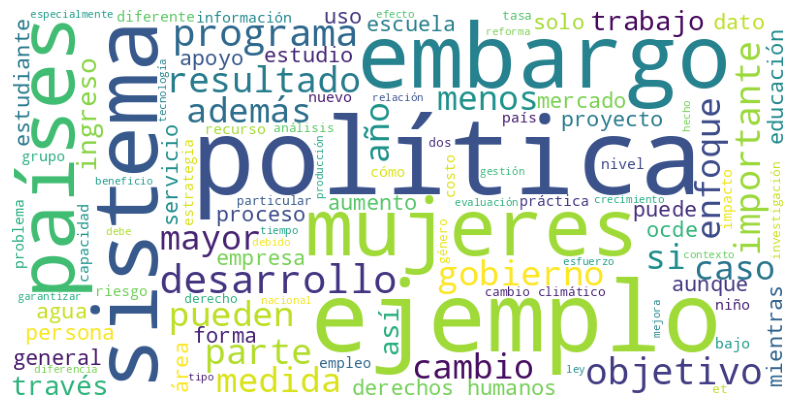

In [21]:
#Visualización inicial de las palabras que contienen los documentos.
texto_nube = preprocesamiento_exploratorio(X_train['textos'])

# Generación Nube de Palabras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color ='white',
    min_font_size=10,
    max_font_size=110,
    max_words=100
).generate(texto_nube)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

***

<span style="font-family:Cambria Math">

Veamos el **Top 20** de las palabras (no vacías) más frecuentes en el *corpus* del conjunto de entrenamiento.
</span>

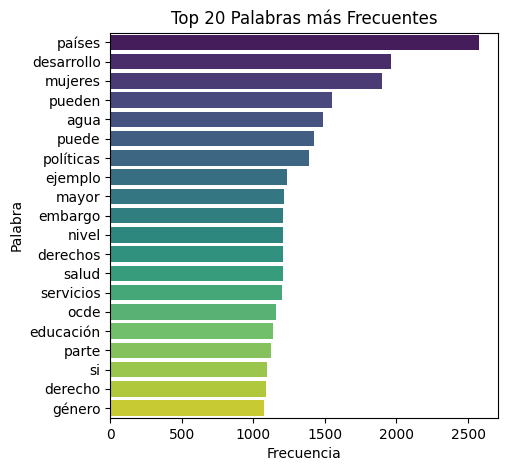

In [22]:
#Conversión a dataframe
def palabras_a_dataframe(texto):
    palabras = texto.split()  # Dividir el texto en palabras por espacios
    conteo = Counter(palabras)  # Contar ocurrencias de cada palabra
    df = pd.DataFrame(conteo.items(), columns=['Palabra', 'Frecuencia'])
    df = df.sort_values(by='Frecuencia', ascending=False).reset_index(drop=True)  # Ordenar y resetear índice
    return df

conteo_palabras = palabras_a_dataframe(texto_nube)
conteo_top = conteo_palabras.head(20)

# Top 20 palabras
plt.figure(figsize=(5, 5))
sns.barplot(x=conteo_top["Frecuencia"], y=conteo_top["Palabra"], palette="viridis")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.title(f"Top {20} Palabras más Frecuentes")
plt.show()

***

<span style="font-family:Cambria Math">

Finalmente, observemos que la distribución de los conjuntos de entrenamiento y prueba con un split estratificado resulta ser adecuada.
</span>

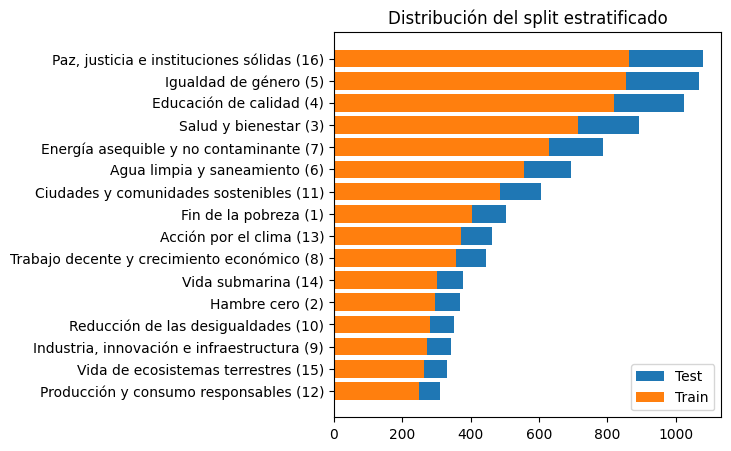

In [23]:
counts = data['ODS'].value_counts()
counts_train = y_train.value_counts()

# Gráfica de la proporcionalidad de las clases y los conjuntos divididos
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.barh(range(0,16), counts, label="Test")
ax.barh(range(0,16), counts_train, label="Train")
ax.set_yticks(range(0,16), labels=[ods[l-1] + f" ({l})" for l in counts.index])
ax.invert_yaxis()
plt.title("Distribución del split estratificado")
plt.legend()
fig.show()

***

<span style="font-family:Cambria Math">

# Preparación de los datos
 

El objetivo de esta sección es incorporar varios estilos de pre-procesamiento, probar diferentes maneras de depurar los textos como por ejemplo remover caracteres no alfanuméricos, a excepción de guiones o apóstrofes. También haremos uso de dos normalizadores: *Stemming* y *Lemmatization*, y la vectorización de los textos se llevará a cabo con la técnica `TF-IDF`. Además, se implementarán dos métodos de reducción de la dimensionalidad: por selección y por transformación.

Si bien la elección de los modelos de clasificación impacta directamente en el rendimiento, para efectos de este micro-proyecto quisiéramos centrarnos en la materia (métodos no supervisados). Por esta razón, se desea experimentar con el pre-procesamiento y la reducción de dimensionalidad, y así observar qué impacto tienen estas técnicas no supervisadas en el rendimiento de los algoritmos supervisados.

Empezaremos definiendo una serie de funciones y clases que permitirán ejecutar el preprocesamiento utilizando *pipelines*. Esto nos permitirá tener un enfoque más modular y abstracto a lo largo del microproyecto.

El primer componente del *pipeline* de preprocesamiento será el siguiente preprocesador base.

</span>

***

<span style="font-family:Cambria Math">

## Preprocesador base

</span>

***

<span style="font-family:Cambria Math">

La función `PorterStemmer()` de `NLTK`, es la que normalmente se ha usado en los laboratorios de este curso. Vale la pena resaltar, que esta función no requiere especificar el idioma porque fue diseñada originalmente para inglés. Creemos que no es compatible con el español de  debido a diferencias en la morfología de las palabras. Es de conocimiento en la comunidad de ML que si se trabaja con textos en español, es recomendable `SnowballStemmer`, que sí admite diferentes idiomas.

Por otro lado, además de  la normalización *stemming*, utilizaremos la *lemmatization*, que obtiene la forma base de una palabra considerando su contexto gramatical. Para ello, utilizaremos la librería `spacy`, que permite especificar el idioma a trabajar.

Las siguientes funciones implementarán estos normalizadores:
</span>


In [24]:
# Stemming
stemmer = SnowballStemmer("spanish")
normalizer_stem = lambda tokens: [stemmer.stem(t) for t in tokens]

# Lemmatization
nlp = spacy.load("es_core_news_sm")
normalizer_lemma = lambda tokens: [t.lemma_ for t in nlp(" ".join(tokens))]

***

<span style="font-family:Cambria Math">

Para estandarizar el preprocesamiento básico que aplicaremos a todos los textos, definiremos una clase basada en `TransformerMixin` (scikit-learn) para heredar el método `fit_transform` y poder utilizarlo dentro de un `Pipeline`. Por lo tanto, es necesario definir la clase con los métodos `fit` y `transform`, de la siguiente forma:

- La clase se inicializa con:
    - Un *tokenizer* basado en una expresión regular compatible con el español, es decir, admite tíldes y la letra ñ; la tokenización se hace a nivel de palabra.
    - Un *normalizer* elegido, por ejemplo, *stemming* o *lemmatization*.
- Implementamos un método `fit` que no tiene ninguna acción, solo por conveniencia. Esto se hace para que, por herencia de la clase `TransformerMixin`, se implemente automáticamente el método `fit_transform`, el cual sí se usará en los *pipelines*.
- Entonces, la transformación ejecuta lo siguiente:
    - Convierte de texto a lista de tokens (palabras) utilizando el *tokenizer* inicializado
    - Convierte todos los tokens a minúsculas
    - Filtra la stopwords en `nltk_stopwords_set`
    - Aplica el *normalizer* elegido
    - Une nuevamente los tokens para formar el texto transformado
</span>

In [25]:
# Definición de la clase pre-procesador
class preprocesador(TransformerMixin):
    def __init__(self, normalizer=None):
        self.tokenizer = RegexpTokenizer(r"\b[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ'-]+")
        # Es obligatorio indicar el normalizador
        if normalizer is None:
            raise ValueError("Ingresa un normalizador")
        self.normalizer = normalizer

    def fit(self, X, y=None):
        return self

    # Preprocesamiento básico que se ejecutará al llamar el método transform de la clase
    def _preprocesamiento_basico(self, X):
        tokens = self.tokenizer.tokenize(X)
        tokens = [t.lower() for t in tokens]
        tokens = [t for t in tokens if t not in nltk_stopwords_set]
        normalized_tokens = self.normalizer(tokens)
        return " ".join(normalized_tokens)

    def transform(self, X, y=None):
        return X.apply(self._preprocesamiento_basico)

***
<span style="font-family:Cambria Math">
    
## Testeando los preprocesadores

A continuación se hace una prueba con *stemming* y *lemmatization* para tener una idea de cómo se transforman los documentos con cada técnica.
</span>


In [26]:
txt = X_train['textos'].iloc[0:1] # El input tiene que ser de tipo pandas Series
print("Original:\n", txt.values[0], "\n")

txt_stem = preprocesador(normalizer_stem).fit_transform(txt)
print("Stem:\n", txt_stem.values[0], "\n")

txt_lemma = preprocesador(normalizer_lemma).fit_transform(txt)
print("Lemma:\n", txt_lemma.values[0])

Original:
 Este artículo explora los distintos enfoques del estudio de la resolución de conflictos desde una variedad de perspectivas interdisciplinarias. Sostiene que la investigación de la RC es sofisticada y llena de matices, ya que aborda tanto las motivaciones a nivel estatal como grupal que subyacen a la violencia política. Aunque a veces se considera que estas dos vertientes ofrecen interpretaciones opuestas del conflicto, sostenemos que son esencialmente complementarias y que tienen mucho que ofrecer a los responsables políticos desde el punto de vista teórico y práctico. 

Stem:
 articul explor distint enfoqu estudi resolu conflict varied perspect interdisciplinari sostien investig rc sofistic llen matic abord motiv nivel estatal grupal subyac violenci polit aunqu vec consider dos vertient ofrec interpret opuest conflict sosten esencial complementari ofrec respons polit punt vist teoric practic 

Lemma:
 artículo explorar distinto enfoque estudiar resolución conflicto variedad

***

<span style="font-family:Cambria Math">

El *stemming* para textos en español suele dar resultados inesperados porque el truncar las palabras puede generar ambiguedades en nuestro idioma, ya que palabras con diferente raíz y significado pueden coincidir después del proceso de *stemming*.

Sin embargo, aún tenemos que ver su desempeño durante la clasificación de textos.
</span>

***

<span style="font-family:Cambria Math">

## Reducción de dimensionalidad por selección vs. transformación


Para el pesado de las palabras se va a utilizar la técnica `TF-IDF` implementada en `TfidfVectorizer` de scikit-learn, con el parámetro `min_df`, el cual establece el mínimo de frecuencia (relativa) en los documentos para que una palabra sea incluida en el vocabulario.

Cuando se ingresa con un valor mayor que 0 o menor que 1, asume que el usuario desea incluir las palabras que aparezcan al menos en

$$\text{min\_df} \times 100\%$$

de los documentos.

Este parámetro en consecuencia reduce el tamaño del espacio de características. Sin embargo, hay que tener en cuenta que si bien se reduce la dimensionalidad, en realidad es más un trabajo de depuración de palabras que no aportan información (termina pareciéndose a un trabajado de reducción de dimensionalidad por selección, pero como se ha observado la en clase, este tipo de reducción puede ser contraindicativo para el rendimiento).

Si este parámetro se ajusta para quitar muchas palabras, es posible que se pierda mucha información, razón por la cual a partir de cierto punto es mejor usar un método de reducción de dimensionalidad basado en transformación, como por ejemplo  `TruncatedSVD`. En particular `TruncatedSVD` es altamente recomendado para matrices dispersas.

Ahora bien, inicialmente sería ideal explorar el efecto del parámetro `min_df` en la dispersión de los datos. Para ello, haremos un pre-procesamiento experimental con `lemma` y `stem`, probando un `min_df` fijo para tener una idea visual.
</span>

In [27]:
min_df = 0.001
print("Por ejemplo, podríamos filtrar aquellas palabras que ocurran con una frecuencia relativa en los documentos menor al", min_df*100, "%")

Por ejemplo, podríamos filtrar aquellas palabras que ocurran con una frecuencia relativa en los documentos menor al 0.1 %


***

<span style="font-family:Cambria Math">

# Visualización de la dimensionalidad resultante

</span>

***

<span style="font-family:Cambria Math">

## *Stemming vs. Lemmatization*

Para tener una idea de las diferencias en dimensionalidad que producen los distintos preprocesamientos, utilizaremos los siguientes pipelines.

(Cabe aclarar que el análisis que corresponde al impacto de los *pipelines* en los modelos de clasificación se hará a partir de la sección "Desarrollo de un modelo de clasificación" de este *notebook*).

</span>

In [28]:
# Pipeline con Stemming, sin depuración de palabras
pipeline_stem = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_stem)),
    ('vectorizer', TfidfVectorizer()),
])

In [29]:
# Pipeline con Stemming + depuración de palabras
pipeline_stem_mind_df = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_stem)),
    ('vectorizer', TfidfVectorizer(min_df=min_df)),
])

In [30]:
# Pipeline con Lemmatization, sin depuración de palabras
pipeline_lemma = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_lemma)),
    ('vectorizer', TfidfVectorizer()),
])

In [31]:
# Pipeline con Lemmatization + depuración de palabras
pipeline_lemma_mind_df = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_lemma)),
    ('vectorizer', TfidfVectorizer(min_df=min_df)),
])

In [32]:
# Aplicando los pipelines -> Obtendremos 4 espacios de características distintos
# Stem
%time X_train_stem = pipeline_stem.fit_transform(X_train['textos'])
%time X_train_stem_min_df = pipeline_stem_mind_df.fit_transform(X_train['textos'])
# Lemma
%time X_train_lemma = pipeline_lemma.fit_transform(X_train['textos'])
%time X_train_lemma_min_df = pipeline_lemma_mind_df.fit_transform(X_train['textos'])

CPU times: user 8.24 s, sys: 1.99 ms, total: 8.25 s
Wall time: 8.28 s
CPU times: user 8.12 s, sys: 3.63 ms, total: 8.12 s
Wall time: 8.15 s
CPU times: user 1min 1s, sys: 8.86 ms, total: 1min 1s
Wall time: 1min 1s
CPU times: user 59.2 s, sys: 3.86 ms, total: 59.2 s
Wall time: 59.6 s


<span style="font-family:Cambria Math">
    
Ahora observemos el número de tokens producido por cada *pipeline* de preprocesamiento

</span>

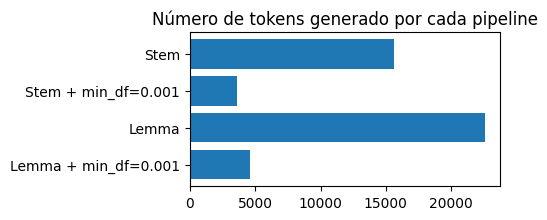

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(4,2))
ax.barh(range(4), [X.shape[1] for X in [X_train_stem, X_train_stem_min_df, X_train_lemma, X_train_lemma_min_df]])
ax.set_yticks(range(4), ["Stem", f"Stem + min_df={min_df}", "Lemma", f"Lemma + min_df={min_df}"])
ax.invert_yaxis()
plt.title("Número de tokens generado por cada pipeline")
fig.show()

<span style="font-family:Cambria Math">

Notamos que Lemmatization genera más tokens que Stemming.

Utilizaremos la siguiente función para visualizar una matriz dispersa y notar las áreas de mayor ocurrencia de tokens

</span>

In [34]:
def plot_matriz_dispersa(M, title):
    M = coo_matrix(M)
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.plot(M.col, M.row, 's', color='black', ms=0.5)
    ax.set_xlim(0, M.shape[1])
    ax.set_ylim(0, M.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(title)
    fig.show()

***

<span style="font-family:Cambria Math">

Esta visualización nos permite notar concentraciones de palabras dentro del *corpus*: Cuando el preprocesamiento no incluye una depuración de palabras, se están admitiendo aquellas que ocurren con muy poca frecuencia y por lo tanto sus columnas correspondientes serán en su mayoría espacios en blanco; por otro lado, cuando filtramos las palabras poco frecuentes, obtendremos columnas más densas y una imagen más oscura.

Esta dispersión es recurrente en los problemas con documentos tipo texto.

</span>

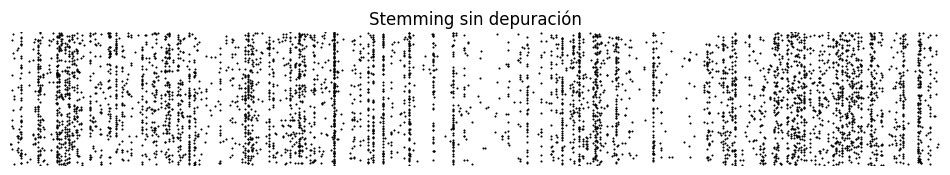

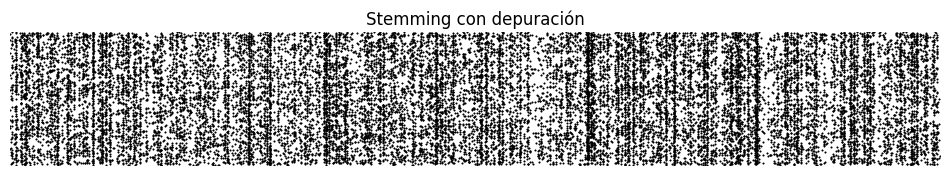

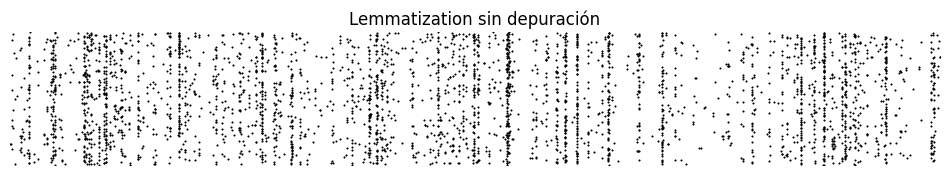

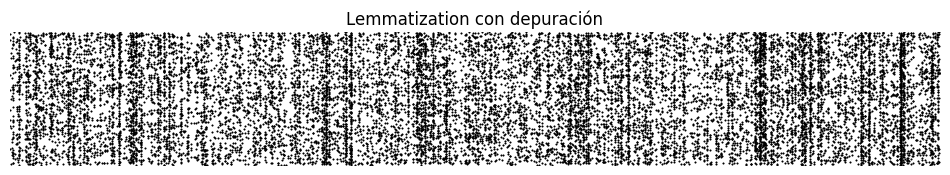

In [35]:
rows = 500
cols = 3500

plot_matriz_dispersa(X_train_stem[:rows,:cols], "Stemming sin depuración")
plot_matriz_dispersa(X_train_stem_min_df[:rows,:cols], "Stemming con depuración")
plot_matriz_dispersa(X_train_lemma[:rows,:cols], "Lemmatization sin depuración")
plot_matriz_dispersa(X_train_lemma_min_df[:rows,:cols], "Lemmatization con depuración")

***

<span style="font-family:Cambria Math">

## *Singular Value Decomposition*

Como se mencionó anteriormente, a partir de cierto punto utilizar el parámetro `min_df` del pesado `TF-IDF` puede generar pérdida de información valiosa. Por ello, se planea en este proyecto complementar el procesamiento de la información con una reducción de dimensionalidad usando `TruncatedSVD` ya que a partir de la descomposiciones de matrices de vectores propios y valores propios se recoge los mayores de aportes de información.

También es importante resaltar que, al usar `TruncatedSVD`, no es necesario aplicar un escalado adicional a los datos, ya que la descomposición SVD incorpora de forma inherente los factores de escala.

Para ver el efecto que tiene SVD realizamos la siguiente visualización:
</span>

In [36]:
# Pipeline con Lemmatization + depuración de palabras + SVD
pipeline_lemma_mind_df_SVD = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_lemma)),
    ('vectorizer', TfidfVectorizer(min_df=min_df)),
    ('reductor_dim', TruncatedSVD(n_components=2000, random_state=RANDOM_STATE ))
])

In [37]:
%time X_train_lemma_min_df_SVD = pipeline_lemma_mind_df_SVD.fit_transform(X_train['textos'])

CPU times: user 3min 1s, sys: 1.44 s, total: 3min 2s
Wall time: 1min 15s


In [38]:
X_train_lemma_min_df_SVD.shape

(7724, 2000)

<span style="font-family:Cambria Math">

La matriz obtenida con SVD es ahora densa, por lo que visualizarla con `plot_matriz_dispersa` ya no tiene sentido.

</span>

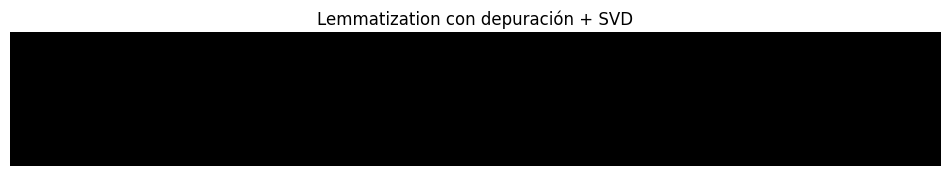

In [39]:
plot_matriz_dispersa(X_train_lemma_min_df_SVD.T[:rows, :cols], "Lemmatization con depuración + SVD")

***

<span style="font-family:Cambria Math">

Como se observa ya no hay vacíos o líneas concentradas, sino que se ve una distribución de puntos homogéneos. Esto se debe a que con la reducción de dimensionalidad vía `TruncatedSVD` los datos se vuelven densos.

Notemos que la dimensión de la matriz depende directamente del número de componente que le asignamos por parámetro a `TruncatedSVD`.
</span>

***

<span style="font-family:Cambria Math">

## Varianza explicada

Utilizando `PCA`, observaremos la varianza explicada por los componentes de cada uno de los cuatro espacios de características obtenidos.

</span>

In [40]:
def plot_varianza_explicada(Xs: dict):

    # Obtener la varianza acumulada (similar a un análisis de Pareto)
    def get_varianza_acumulada(X):
        pca = PCA().fit(X.toarray())
        var_acumulada = np.cumsum(pca.explained_variance_ratio_)
        return var_acumulada
    exp_var = 0.90

    plt.figure(figsize=(12, 6))

    colores = ['red', 'orange', 'blue', 'skyblue']

    for i, (X_str, X) in enumerate(Xs.items()):
        var_acumulada = get_varianza_acumulada(X)
        plt.plot(np.arange(1, len(var_acumulada)+1), var_acumulada, color=colores[i], alpha=1, label=X_str)
        d = np.argmax(var_acumulada >= exp_var) + 1
        plt.axvline(x=d, color=colores[i], linestyle='--', linewidth=1)

    plt.yticks(np.arange(0,1+0.1,0.1))
    plt.xlabel('Tokens')
    plt.ylabel('Varianza explicada')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.5)
    plt.show()

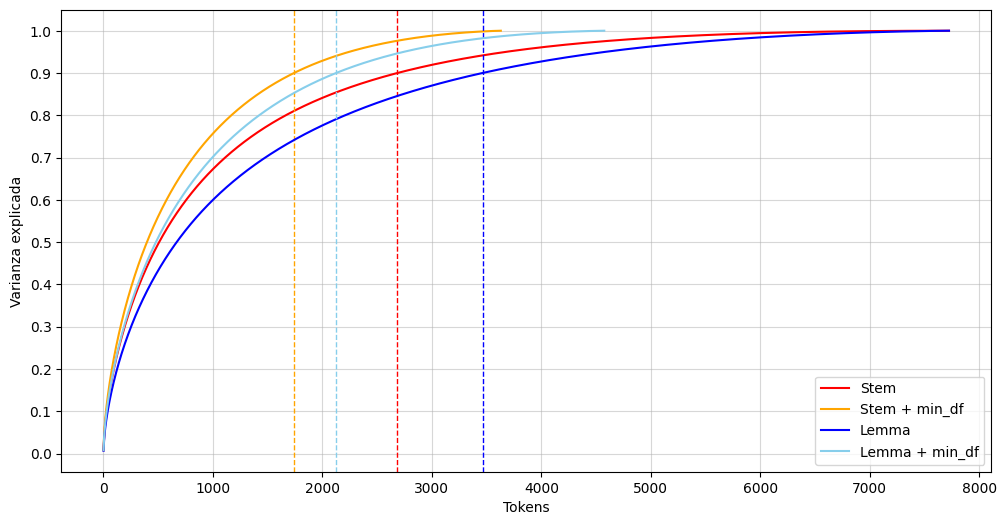

CPU times: user 1h 56min 14s, sys: 25.8 s, total: 1h 56min 39s
Wall time: 10min 40s


In [41]:
Xs = {
    'Stem': X_train_stem,
    'Stem + min_df': X_train_stem_min_df,
    'Lemma': X_train_lemma,
    'Lemma + min_df': X_train_lemma_min_df,
}
%time plot_varianza_explicada(Xs)

***

<span style="font-family:Cambria Math">
    
La gráfica anterior nos muestra los diferentes modelos de pre-procesamiento que tenemos incluyendo *lemmatization* y *stemming* con y sin el uso del parámetro `min_df` en `TF-IDF`. El permitir un mayor número de *tokens* va generar una mayor explicación de la varianza de los datos. Sin embargo, el objetivo de generar una reducción de dimensionalidad es encontrar el punto "justo" entre la explicación de la variación y la eficiencia en el procesamiento. Por esta razón, se muestra para cada pipeline la cantidad de tokens que explica la mayor parte de la varianza (aproximadamente el 90%).

Como se puede apreciar, alrededor de 2000 a 3500 tokens son suficientes para explicar aproximadamente el 90% de la varianza.

</span>

***

<span style="font-family:Cambria Math">
    
Recordemos que no es lo mismo reducir dimensionalidad vía selección que via transformación. A continuación vemos un ejemplo vía **transformación** `TruncatedSVD`. Con tan solo 1.404 features (o en realidad más exáctamente "componentes") se explica el 90% de la varianza de los datos.

</span>

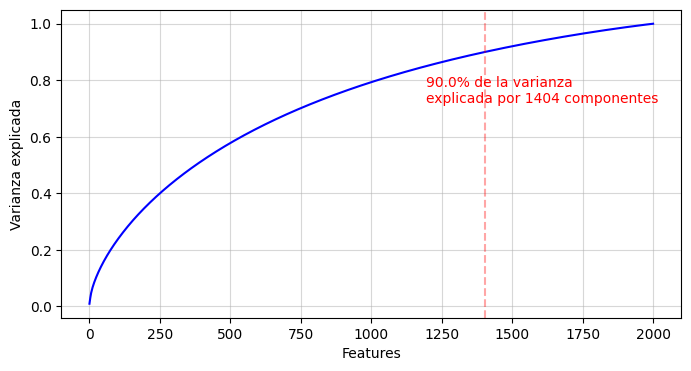

In [42]:
def plot_varianza_explicada_2(X):
    pca = PCA().fit(X)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    exp_var = 0.90

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(1,len(cumsum)+1), cumsum, linestyle='-', color='b')
    d = np.argmax(cumsum >= exp_var) + 1
    plt.axvline(x=d, color='red', linestyle='--', alpha=0.35)
    plt.text(d*0.85, exp_var*0.80, f"{exp_var*100}% de la varianza \nexplicada por {d} componentes", color='r')

    plt.xlabel('Features')
    plt.ylabel('Varianza explicada')
    plt.grid(True, alpha=0.5)
    plt.title("")
    plt.show()

plot_varianza_explicada_2(X_train_lemma_min_df_SVD)

***

<span style="font-family:Cambria Math">

## t-SNE

</span>

***

<span style="font-family:Cambria Math">
    
Finalmente, en cuanto a visualización corresponde, nos parece importante conocer mediante el uso de la técnica `t-SNE` cómo las diferentes maneras de pre-procesar los datos generan "*clusters*" en una proyección 2D del espacio de características. Esto nos permite ver el impacto del preprocesamiento en la representación vectorial de los documentos del corpus:

</span>

In [43]:
def plot_tSNE(X, perplexity=30):
    tsne = TSNE(n_components=2, init='random', random_state=RANDOM_STATE, perplexity=perplexity).fit_transform(X)
    fig, axs = plt.subplots(4, 4, figsize=(15, 10))
    axs_flat = axs.flatten()
    colores = sns.color_palette("hls", 16)
    for i in range(16):
        tsne_ods = tsne[y_train == i+1]
        tsne_otros = tsne[y_train != i+1]
        axs_flat[i].scatter(tsne_otros[:,0], tsne_otros[:,1], c='black', s=2, alpha=0.01)
        axs_flat[i].scatter(tsne_ods[:,0], tsne_ods[:,1], c=colores[i], s=8, alpha=0.25)
        axs_flat[i].set_title(f"ODS {i+1}")
        axs_flat[i].set_axis_off()
    plt.show()

<span style="font-family:Cambria Math">

Observemos las proyecciones en 2D de los espacios de características generados con 3 distintos pipelines de preprocesamiento, utilizando un mismo valor `perplexity=30` para los 3 casos:

</span>

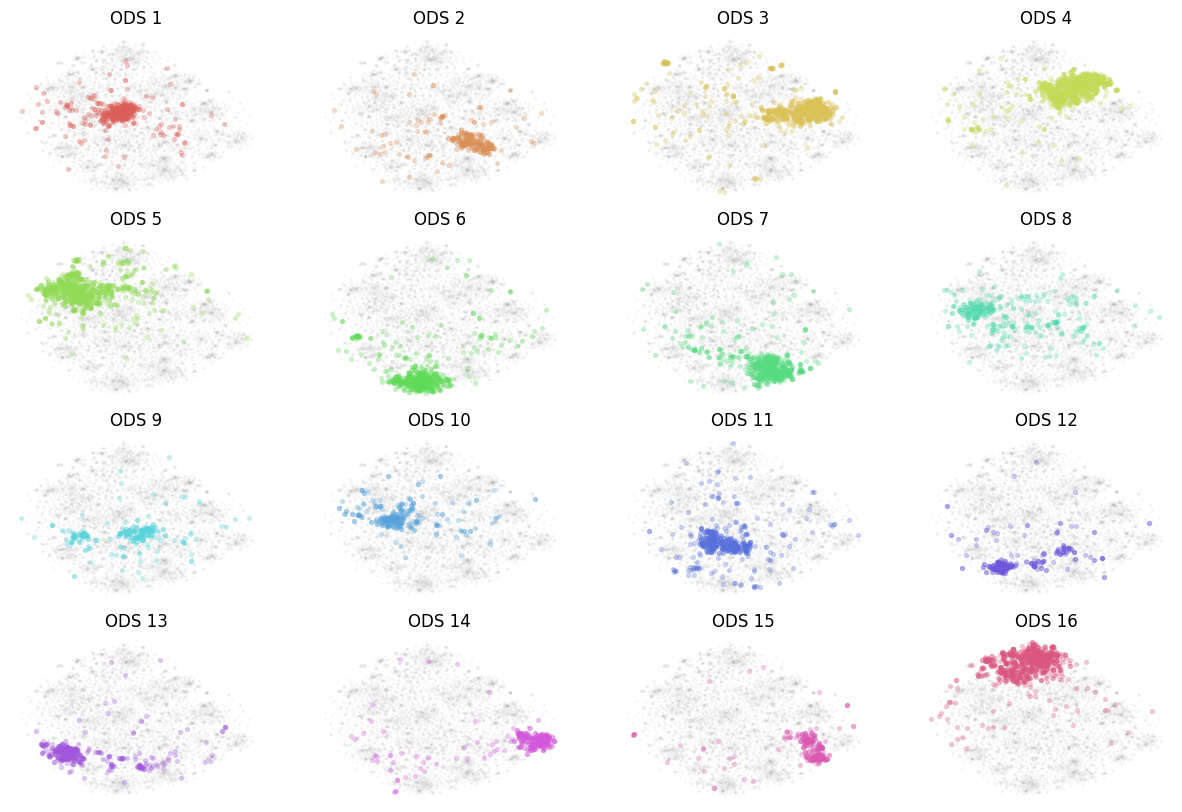

CPU times: user 2min 19s, sys: 236 ms, total: 2min 19s
Wall time: 26.1 s


In [44]:
# Impacto de Stemming
%time plot_tSNE(X_train_stem)

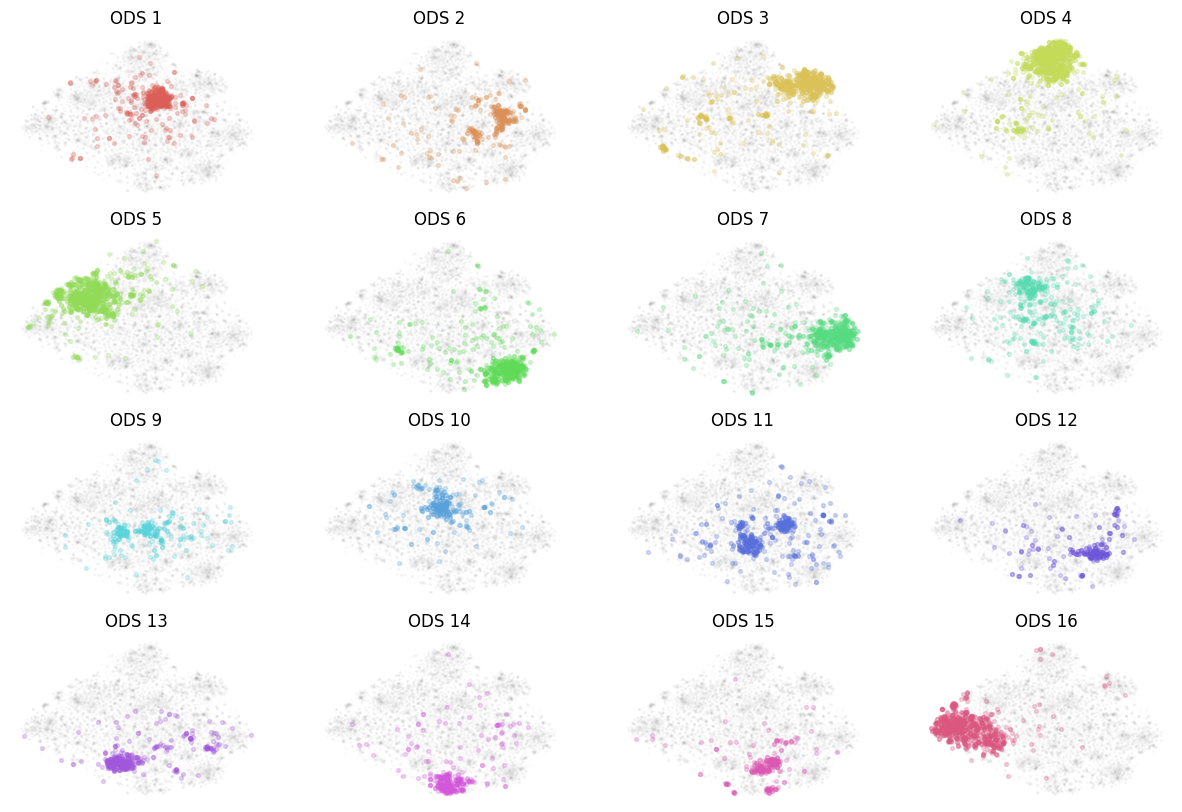

CPU times: user 2min 5s, sys: 243 ms, total: 2min 5s
Wall time: 23.8 s


In [45]:
# Impacto de Lemmatization + min_df
%time plot_tSNE(X_train_lemma_min_df)

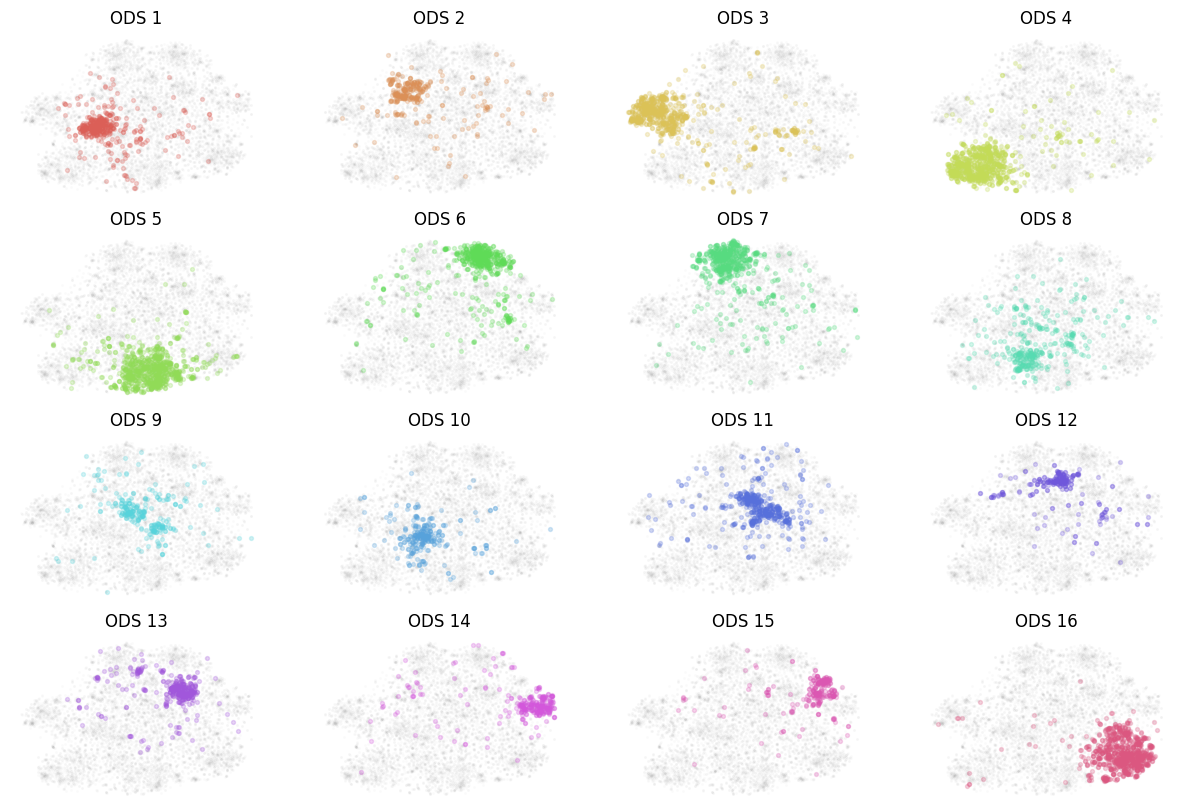

CPU times: user 2min 8s, sys: 144 ms, total: 2min 8s
Wall time: 22.8 s


In [46]:
# Impacto de Lemmatization + min_df + SVD
%time plot_tSNE(X_train_lemma_min_df_SVD)

***

<span style="font-family:Cambria Math">

`t-SNE` logra retener las características principales en cada clase, por lo que observamos, en general,  consistencia en el cómo se muestra la información a través de los diferentes modos de pre-procesamiento de los datos en los 3 casos.

Podríamos "tipificar" las clases visualizadas con las siguientes características:

- Clases con un alto número de representantes (tokens) y separación bien definida. (Por ejemplo 3, 4, 5 y 16).
- Clases con un número reducido de representantes pero que mantienen una separación definida. (Por ejemplo 6, 7 y 14)
- Clases que si bien presentan una región de densidad, tienen representantes dispersos por todo el "mapa". (Por ejemplo 1, 2, 12, 13, y 15).
- Clases con densidad muy baja, no presentan una línea de separación muy clara y sus representantes están dispersos por todo el mapa (Por ejemplo 8, 9 y 10).

Lo que se puede inferir de esta tipificación de clases es que unas serán más fáciles de distinguir que otras por la combinación de tokens usados. Esto significa que hay un sub-conjunto de tokens asociable a algunas clases en particular. Sin embargo, habrán otras clases que sus "tokens" o más propiamente sus "componentes" significativos están más dispersos,  por lo serán más dificil de predecir.

</span>

***

<span style="font-family:Cambria Math">

# Desarrollo de un modelo de clasificación

***

Pasamos a la definición de los modelos que se pasarán como *input* en los *pipelines* a probar. En realidad en esta parte, no quisiéramos explicar demasiado detalle, ya que como mencionamos anteriormente el objetivo de este proyecto es poder concentrarnos en los algoritmos no supervisados.

Sin embargo, mencionamos que se probarán los modelos `LogisticRegression`, `MultinomialNB`  y `RidgeClassifier` usando en cada uno de ellos la mejor versión a partir de la búsqueda de grilla de hiperparámetros (`GridSearchCV`).

La justificación para su uso es la siguiente:

- `LogisticRegression` es un modelo discriminativo robusto con espacios de alta dimensionalidad (como los generados por `TfidfVectorizer`). Además, su capacidad de regularización permite evitar el sobreajuste y mejorar el desempeño en tareas de clasificación textual.
- `MultinomialNB` es un modelo generativo rápido y eficiente. Se menciona en [esta documentación de scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) que también es  compatible con el output generado por un vectorizador como `TfidfVectorizer`.
- `RidgeClassifier` representa la alternativa lineal que utiliza regularización tipo ridge para evitar el sobreajuste, proporcionando precisión y estabilidad.

***

Para correr pruebas/predicciones individuales, definiremos una función que muestra el texto original, el ODS predicho y su correspondiente ODS real. Incluiremos esta función dentro de las funciones que facilitan la implementación de los clasificadores.
</span>

In [47]:
def correr_prueba_individual(Xtest, modelo, num_textos):
    indices = np.random.randint(0, Xtest.shape[0], num_textos)
    for i in indices:
        pred = modelo.predict(Xtest[i])
        print("\n", f"Predicción: ODS {pred}", ods[pred-1], "(ODS real: ", y_test.iloc[i], ")")
        print("-"*100)
        print(X_test['textos'].iloc[i])
    return

***
<span style="font-family:Cambria Math">

### Modelo 1: Regresión Logística

</span>

In [48]:
def predecir_LogReg(Xtrain, Xtest, prueba_individual=False, num_textos=None):
    logreg = GridSearchCV(
        LogisticRegression(max_iter=500, random_state=RANDOM_STATE, class_weight='balanced'),
        {'penalty': ['l1','l2'], 'C': [1,5,10,20]},
        scoring='neg_log_loss',
        n_jobs=-1
    )
    logreg.fit(Xtrain, y_train)

    # Prueba individual
    if prueba_individual and isinstance(num_textos, int):
        correr_prueba_individual(Xtest, modelo=logreg, num_textos=num_textos)
        return

    # Prueba agregada
    y_pred = logreg.predict(Xtest)
    print(f"Accuracy del modelo Logístico: {accuracy_score(y_test, y_pred):.4f}", " ---> Best Params: ", logreg.best_params_)
    return classification_report(y_test, y_pred, output_dict=True)

***
<span style="font-family:Cambria Math">

### Modelo 2: Multinomial Naive Bayes
</span>

In [49]:
def predecir_MultinomialNaiveBayes(Xtrain, Xtest, prueba_individual=False, num_textos=None):
    mnb = GridSearchCV(
        MultinomialNB(fit_prior=False),
        {'alpha': np.arange(0.05, 1, 0.05)},
        scoring='neg_log_loss',
        n_jobs=-1
    )
    mnb.fit(Xtrain, y_train)

    # Prueba individual
    if prueba_individual and isinstance(num_textos, int):
        correr_prueba_individual(Xtest, modelo=mnb, num_textos=num_textos)
        return

    # Prueba agregada
    y_pred = mnb.predict(Xtest)
    print(f"Accuracy del modelo Naive Bayes: {accuracy_score(y_test, y_pred):.4f}", " ---> Best Params: ", mnb.best_params_)
    return classification_report(y_test, y_pred, output_dict=True)

***
<span style="font-family:Cambria Math">

### Modelo 3: Ridge Classifier
</span>

In [50]:
def predecir_RidgeClassifier(Xtrain, Xtest, prueba_individual=False, num_textos=None):
    ridge = GridSearchCV(
        RidgeClassifier(random_state=RANDOM_STATE),
        param_grid={'alpha': np.arange(0.05, 1, 0.05)},
        n_jobs=-1
    )
    ridge.fit(Xtrain, y_train)

    # Prueba individual
    if prueba_individual and isinstance(num_textos, int):
        correr_prueba_individual(Xtest, modelo=ridge, num_textos=num_textos)
        return

    # Prueba agregada
    y_pred = ridge.predict(Xtest)
    print(f"Accuracy del modelo Ridge: {accuracy_score(y_test, y_pred):.4f}", " ---> Best Params: ", ridge.best_params_)
    return classification_report(y_test, y_pred, output_dict=True)

***
<span style="font-family:Cambria Math">

## Prueba piloto de los clasificadores (individual)

</span>

In [51]:
%time X_test_lemma_min_df = pipeline_lemma_mind_df.transform(X_test['textos'])

CPU times: user 17.5 s, sys: 1.91 ms, total: 17.5 s
Wall time: 17.6 s


In [52]:
# Logistic Regression
predecir_LogReg(X_train_lemma_min_df, X_test_lemma_min_df, prueba_individual=True, num_textos=2)


 Predicción: ODS [6] ['Agua limpia y saneamiento'] (ODS real:  6 )
----------------------------------------------------------------------------------------------------
Considerando la restricción del área, se propone construir una PTAR combinada (en bloque) con estructuras de hormigón armado. Las aguas residuales tratadas se descargarán en diferentes partes del río Dalarik y también en el río Hrazdan, aumentando los recursos hídricos del río y permitiendo el riego de áreas agrícolas más grandes. Sin embargo, es importante señalar que permitir diferentes puntos de descarga generaría costos adicionales, ya que requeriría un sistema de tuberías y válvulas. Alternativamente, todos los flujos podrían descargarse en el río en un solo punto.

 Predicción: ODS [5] ['Igualdad de género'] (ODS real:  5 )
----------------------------------------------------------------------------------------------------
Aunque los altos cargos dirigen muchas unidades de género, a algunas no se les asignan presu

In [53]:
# Multinomial NB
predecir_MultinomialNaiveBayes(X_train_lemma_min_df, X_test_lemma_min_df, prueba_individual=True, num_textos=2)


 Predicción: ODS [13] ['Acción por el clima'] (ODS real:  13 )
----------------------------------------------------------------------------------------------------
Esto significa que todo el mundo tiene que hacer lo que esté en su mano para frenar las emisiones climáticas, nada menos. La verdadera prueba será cuando las NDC se renueven cada cinco años, tras un balance global y una evaluación de las acciones emprendidas. Un verdadero éxito, y la superación del dilema de las acciones colectivas, sería que las futuras NDC implicaran conjuntamente políticas climáticas más ambiciosas para el planeta, cerrando la brecha para cumplir el objetivo de los dos grados.

 Predicción: ODS [9] ['Industria, innovación e infraestructura'] (ODS real:  9 )
----------------------------------------------------------------------------------------------------
El segundo destacó la importancia de las medidas gubernamentales de apoyo a la innovación y los negocios de base tecnológica. Fueron la fuente de vari

In [54]:
# Ridge
predecir_RidgeClassifier(X_train_lemma_min_df, X_test_lemma_min_df, prueba_individual=True, num_textos=2)


 Predicción: ODS [3] ['Salud y bienestar'] (ODS real:  3 )
----------------------------------------------------------------------------------------------------
Al mismo tiempo, la base de ingresos se contrajo, provocando una caída de los ingresos totales del gobierno en términos nominales de alrededor del 7%. Aunque el gasto en salud como porcentaje del gasto total del gobierno se mantuvo razonablemente constante durante este tiempo, la deuda pública aumentó rápidamente (más del doble como porcentaje del PIB) para hacer frente a la caída de los ingresos del gobierno. Esto incluyó cambios en la política de cargos al usuario y la elegibilidad del sector público con el objetivo de aumentar los ingresos y reducir la demanda innecesaria de servicios. También hubo llamados renovados para implementar el nuevo sistema universal de salud (ver Cuadro 1).

 Predicción: ODS [16] ['Paz, justicia e instituciones sólidas'] (ODS real:  16 )
------------------------------------------------------------

***
<span style="font-family:Cambria Math">

## Prueba piloto de un solo clasificador (agregada)
Ahora predecimos los ODS de todo el conjunto *test* para ver el comportamiento de nuestro clasificador.
</span>


In [55]:
pd.DataFrame(predecir_RidgeClassifier(X_train_lemma_min_df, X_test_lemma_min_df))

Accuracy del modelo Ridge: 0.9053  ---> Best Params:  {'alpha': 0.9500000000000001}


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,accuracy,macro avg,weighted avg
precision,0.893617,0.891892,0.935135,0.918552,0.919283,0.922535,0.898810,0.662791,0.800000,0.836364,0.915966,0.896552,0.88172,0.972973,0.968254,0.966981,0.90528,0.892589,0.904106
recall,0.831683,0.891892,0.966480,0.990244,0.957944,0.942446,0.955696,0.640449,0.753623,0.657143,0.893443,0.838710,0.88172,0.960000,0.924242,0.949074,0.90528,0.877174,0.905280
f1-score,0.861538,0.891892,0.950549,0.953052,0.938215,0.932384,0.926380,0.651429,0.776119,0.736000,0.904564,0.866667,0.88172,0.966443,0.945736,0.957944,0.90528,0.883790,0.903853
support,101.000000,74.000000,179.000000,205.000000,214.000000,139.000000,158.000000,89.000000,69.000000,70.000000,122.000000,62.000000,93.00000,75.000000,66.000000,216.000000,0.90528,1932.000000,1932.000000


<span style="font-family:Cambria Math">

Notemos que las clases con las tres peores métricas de clasificación (`precision`, `recall`, `f1-score`) son los ODS 8, 9 y 10, y son los que anteriormente tipificamos como poco densos y más dispersos. A continuación, mostramos nuevamente la representación 2D del espacio de características para comprobar visualmente estas afirmaciones.

</span>

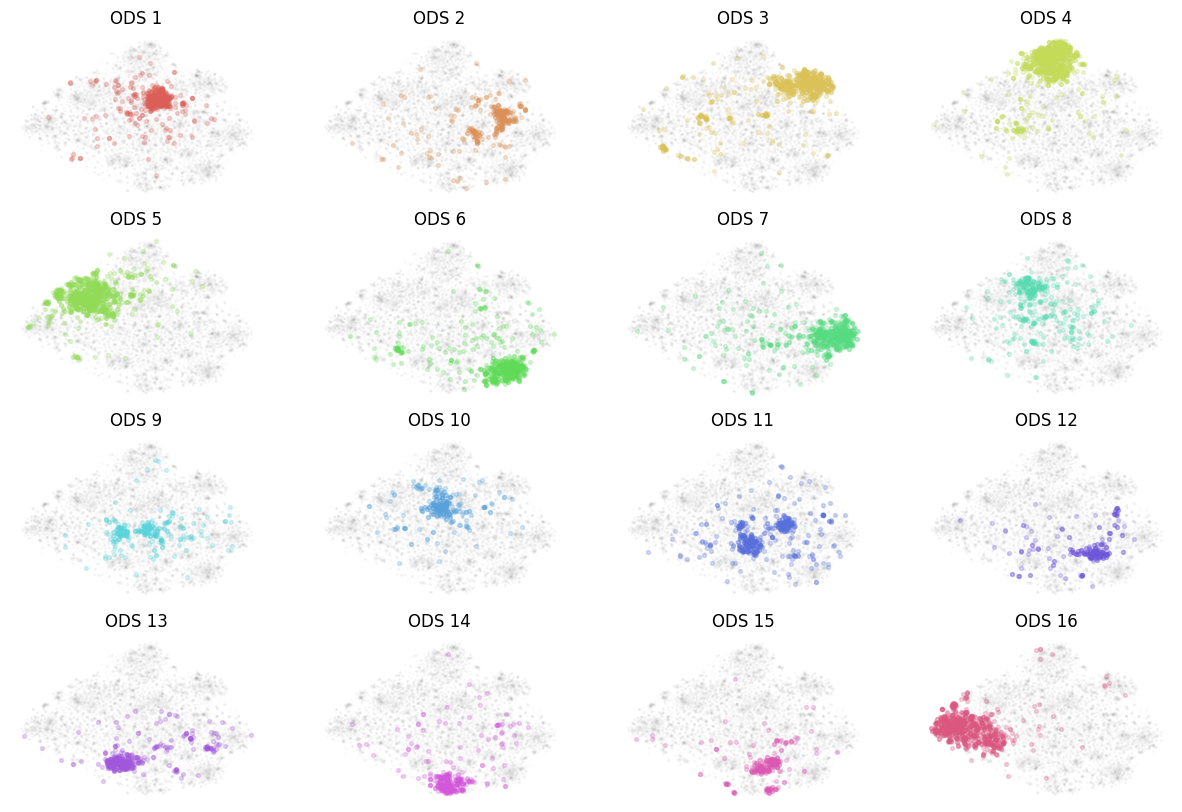

CPU times: user 2min 14s, sys: 385 ms, total: 2min 14s
Wall time: 24.9 s


In [56]:
%time plot_tSNE(X_train_lemma_min_df)

***
<span style="font-family:Cambria Math">

A continuación haremos una evaluación agregada de los modelos.

# Evaluación de los pipelines de preprocesamiento y modelos de clasificación

Ahora procedemos con la parte más importante del micro-proyecto y es correr todo el flujo del *pipeline*. Esto implica definir los *pipelines* "candidatos".

Para ello, definimos un *pool* de *pipelines* con solo reducción de dimensionalidad por selección/depuración de términos y otro *pool* de *pipelines* con reducción de dimensionalidad que también incluya transformación mediante `TruncatedSVD`. La razón es que en primer lugar, deseamos encontrar el nivel adecuado de `min_df` que permita reducir el tamaño de los vectores de palabas sin una pérdida tan importante de información.

</span>

***
<span style="font-family:Cambria Math">

## Pipelines: Reducción por selección

</span>

In [57]:
#Definición de pipelines
pipeline_stem_mindf_0_005 = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_stem)),
    ('vectorizer', TfidfVectorizer(min_df=0.005))
])

pipeline_stem_mindf_0_001 = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_stem)),
    ('vectorizer', TfidfVectorizer(min_df=0.001))
])

pipeline_stem_mindf_1 = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_stem)),
    ('vectorizer', TfidfVectorizer(min_df=1))
])

pipeline_lemma_mindf_0_005 = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_lemma)),
    ('vectorizer', TfidfVectorizer(min_df=0.005))
])

pipeline_lemma_mindf_0_001 = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_lemma)),
    ('vectorizer', TfidfVectorizer(min_df=0.001))
])

pipeline_lemma_mindf_1 = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_lemma)),
    ('vectorizer', TfidfVectorizer(min_df=1))
])

In [58]:
#Diccionario de pipelines
pipelines = {
    'Stem, min_df=0.005': pipeline_stem_mindf_0_005,
    'Stem, min_df=0.001': pipeline_stem_mindf_0_001,
    'Stem, min_df=1.00': pipeline_stem_mindf_1,
    'Lemma, min_df=0.005': pipeline_lemma_mindf_0_005,
    'Lemma, min_df=0.001': pipeline_lemma_mindf_0_001,
    'Lemma, min_df=1.00': pipeline_lemma_mindf_1
}

In [59]:
def benchmark(pipelines: dict, X_train=X_train, X_test=X_test, excluir_nb=False):

    # Definir clasificadores según el parámetro excluir_nb
    if excluir_nb:
        clasificadores = [
            ('LogReg', predecir_LogReg),
            ('RidgeClassifier', predecir_RidgeClassifier)
        ]
    else:
        clasificadores = [
            ('LogReg', predecir_LogReg),
            ('MultinomialNB', predecir_MultinomialNaiveBayes),
            ('RidgeClassifier', predecir_RidgeClassifier)
        ]

    # Guardar resultados: {clasificador: {pipeline: {métrica: valor}}}
    resultados = {clf: {} for clf, _ in clasificadores}

    # Loop por pipeline
    for p_name, pipe in pipelines.items():
        Xtrain_pipe = pipe.fit_transform(X_train['textos'])
        Xtest_pipe = pipe.transform(X_test['textos'])

        # Loop por clasificador
        for clf_name, clf_func in clasificadores:
            rep = clf_func(Xtrain_pipe, Xtest_pipe)
            # Métricas de evaluación
            resultados[clf_name][p_name] = {
                'accuracy': rep['accuracy'],
                'precision': rep['macro avg']['precision'],
                'recall': rep['macro avg']['recall'],
                'f1': rep['macro avg']['f1-score']
            }

    # Métricas (nombres)
    metricas = ['accuracy', 'precision', 'recall', 'f1']
    pipeline_names = list(pipelines.keys())

    # Asignar un color distinto para cada pipeline
    colores = ['lightcoral', 'orangered', 'darkred', 'skyblue', 'royalblue', 'darkblue'][:len(pipeline_names)]

    # Crear grilla 3x4 (o 2x4 si se excluye NB): filas = clasificadores, columnas = métricas
    fig, axs = plt.subplots(len(clasificadores), 4, figsize=(12, 8))
    for i, (clf, res) in enumerate(resultados.items()):
        for j, met in enumerate(metricas):
            ax = axs[i, j]
            ax.set_axisbelow(True)
            ax.grid(True, alpha=0.5)
            for k, p in enumerate(pipeline_names):
                valor = res[p][met]
                ax.bar(k, res[p][met], color=colores[k])
                ax.text(k, valor + 0.005, f"{valor:.3f}", ha='center', va='bottom', fontsize=8)
            # Formato del plot
            ax.set_xticks([])
            ax.set_ylim(0.75, 1.00)
            ax.yaxis.set_ticks(np.arange(0.75, 1.00, 0.05))
            if i == 0:
                ax.set_title(met)
            if j == 0:
                ax.set_ylabel(clf, rotation=0, labelpad=50, va='center')

    # Crear leyenda global encima de todo el gráfico
    handles = [mpatches.Patch(color=colores[k], label=pipeline_names[k]) for k in range(len(pipeline_names))]
    fig.legend(handles=handles, loc='upper center', ncol=3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Accuracy del modelo Logístico: 0.8608  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Naive Bayes: 0.8318  ---> Best Params:  {'alpha': 0.05}
Accuracy del modelo Ridge: 0.8773  ---> Best Params:  {'alpha': 0.9500000000000001}
Accuracy del modelo Logístico: 0.8887  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Naive Bayes: 0.8582  ---> Best Params:  {'alpha': 0.05}
Accuracy del modelo Ridge: 0.9001  ---> Best Params:  {'alpha': 0.7000000000000001}
Accuracy del modelo Logístico: 0.8954  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Naive Bayes: 0.8644  ---> Best Params:  {'alpha': 0.05}
Accuracy del modelo Ridge: 0.9058  ---> Best Params:  {'alpha': 0.8}
Accuracy del modelo Logístico: 0.8628  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Naive Bayes: 0.8447  ---> Best Params:  {'alpha': 0.05}
Accuracy del modelo Ridge: 0.8784  ---> Best Params:  {'alpha': 0.9500000000000001}
Accuracy del modelo Logístico: 0.89

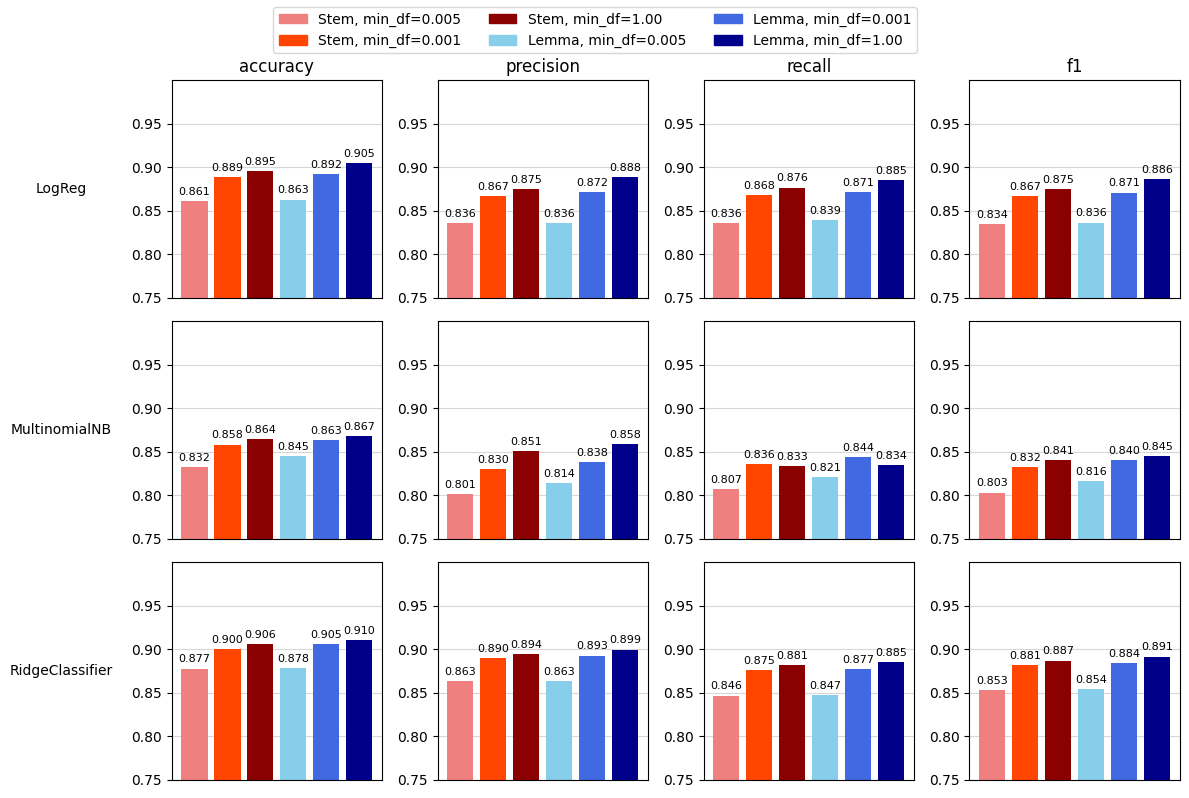

CPU times: user 14min 33s, sys: 2min 23s, total: 16min 57s
Wall time: 8min 26s


In [60]:
%time benchmark(pipelines)

***
<span style="font-family:Cambria Math">

De la anterior gráfica se puede observar que el valor del parámetro `min_df` que genera un mejor `accuracy` para todos los modelos, es aquel que no recorta la cantidad de palabras (`min_df=1`). Sin embargo, este valor no es óptimo porque se podría reducir el número de *tokens*  sin tener un impacto significativo en el  `accuracy` pero obteniendo eficiencia computacional. Cuando se cambia el parámetro de `min_df` de 0.001 a 0.005, empezamos a ver una caída importante en el `accuracy`. Lo que sugiere que 0.001 (u otro valor muy cercano) tal vez sea la mejor elección para el `min_df`.

Adicionalmente, en esta primera iteración el que tuvo mejor desempeño fue el modelo *Ridge* con *lemmmatization*, `min_df` = 1, y `alpha` de 0.65 generando un `accuracy` de 0.91. Sin embargo, como se mencionó antes, es necesaria una reducción de dimensionalidad para mejorar la eficiencia computacional del modelo, y además evitar el sobreajuste en el largo plazo, pues solo consideraríamos los términos/tokens más informativos.

</span>

***
<span style="font-family:Cambria Math">

## Pipelines: Reducción por selección + transformación

Ahora con el mejor valor de `min_df` procedemos a ejecutar los modelos, esta vez incluyendo dentro del *pipeline* el uso de la reducción de dimensionalidad **por transformación** vía  `TruncatedSVD`. Definimos probar un número de componentes entre 1000 y 2000 para cada caso con el parámetro de `min_df` adecuado, encontrado en el paso anterior.

Para esta corrida desafortunadamente `MultinomialNB` no es compatible con la transformación `TruncatedSVD` ya que no acepta valores negativos. Un solución podría ser volver escalar los datos de los componentes para que queden mayor a 0, sin embargo, esto puede generar ruido en los datos por lo que optamos por simplemente descartar este clasificador para efectos de esta etapa.

</span>


In [61]:
#Definición de pipelines
pipeline_stem_mindf_0_001_100comp = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_stem)),
    ('vectorizer', TfidfVectorizer(min_df=0.001)),
    ('reductor_dim', TruncatedSVD(n_components=1000, random_state=RANDOM_STATE ))
])

pipeline_stem_mindf_0_001_200comp = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_stem)),
    ('vectorizer', TfidfVectorizer(min_df=0.001)),
    ('reductor_dim', TruncatedSVD(n_components=2000, random_state=RANDOM_STATE ))
])

pipeline_lemma_mindf_0_001_100comp = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_lemma)),
    ('vectorizer', TfidfVectorizer(min_df=0.001)),
    ('reductor_dim', TruncatedSVD(n_components=1000, random_state=RANDOM_STATE ))
])

pipeline_lemma_mindf_0_001_200comp = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_lemma)),
    ('vectorizer', TfidfVectorizer(min_df=0.001)),
    ('reductor_dim', TruncatedSVD(n_components=2000, random_state=RANDOM_STATE ))
])

pipeline_lemma_mindf_1_200comp = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_lemma)),
    ('vectorizer', TfidfVectorizer(min_df=1)),
    ('reductor_dim', TruncatedSVD(n_components=2000, random_state=RANDOM_STATE ))
])

pipeline_stem_mindf_1_200comp = Pipeline([
    ('preprocesador', preprocesador(normalizer=normalizer_stem)),
    ('vectorizer', TfidfVectorizer(min_df=1)),
    ('reductor_dim', TruncatedSVD(n_components=2000, random_state=RANDOM_STATE ))
])

In [62]:
# Diccionario de pipelines
pipelines_svd = {
    'Stem, min_df=0.001, n_components=1000': pipeline_stem_mindf_0_001_100comp,
    'Stem, min_df=0.001, n_components=2000': pipeline_stem_mindf_0_001_200comp,
    'Stem, min_df=1.00, n_components=2000': pipeline_stem_mindf_1_200comp,
    'Lemma, min_df=0.001, n_components=1000': pipeline_lemma_mindf_0_001_100comp,
    'Lemma, min_df=0.001, n_components=2000': pipeline_lemma_mindf_0_001_200comp,
    'Lemma, min_df=1.00, n_components=2000': pipeline_lemma_mindf_1_200comp
}

Accuracy del modelo Logístico: 0.8732  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Ridge: 0.8934  ---> Best Params:  {'alpha': 0.35000000000000003}
Accuracy del modelo Logístico: 0.8830  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Ridge: 0.9001  ---> Best Params:  {'alpha': 0.9500000000000001}
Accuracy del modelo Logístico: 0.8856  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Ridge: 0.9027  ---> Best Params:  {'alpha': 0.8}
Accuracy del modelo Logístico: 0.8768  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Ridge: 0.8913  ---> Best Params:  {'alpha': 0.9500000000000001}
Accuracy del modelo Logístico: 0.8872  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Ridge: 0.9042  ---> Best Params:  {'alpha': 0.9500000000000001}
Accuracy del modelo Logístico: 0.8939  ---> Best Params:  {'C': 20, 'penalty': 'l2'}
Accuracy del modelo Ridge: 0.9068  ---> Best Params:  {'alpha': 0.9000000000000001}


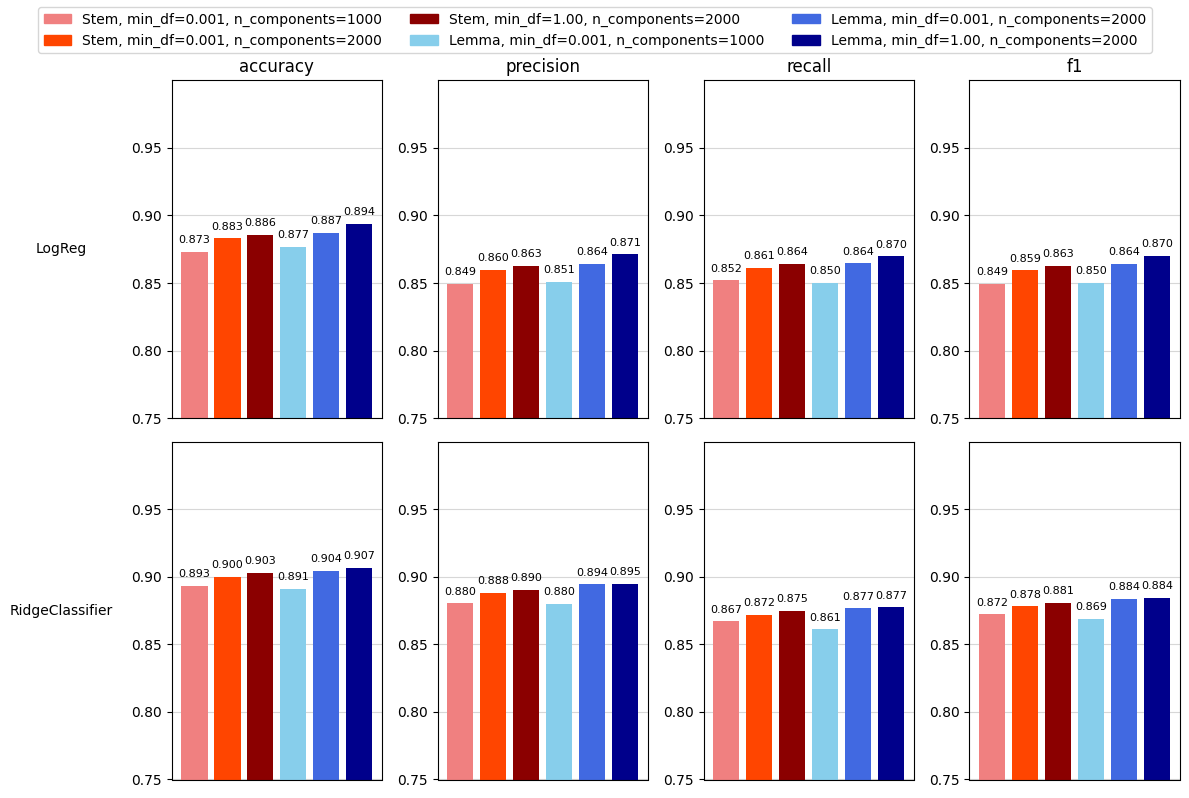

CPU times: user 30min 56s, sys: 4min 53s, total: 35min 50s
Wall time: 11min 11s


In [63]:
%time benchmark(pipelines_svd, excluir_nb= True )

***
<span style="font-family:Cambria Math">

Como es de esperarse, en el SVD reducimos la dimensionalidad de los datos, lo que al inicio puede ser computacionalmente costoso mientras se hacen las transformaciones vectoriales, pero si `TruncatedSVD` es almancenado, en realidad en el largo plazo permitiría tener mayores eficiencias, con el único costo de ser ahora **menos interpretable** por la transformación realizada.

Frente a los resultados obtenidos, observamos que las mejores métricas siguen estando en *Ridge* con *lemmatization*, ahora con un número de componentes de 2000; pero en realidad, los 4 mejores pipelines, aplicados tanto con LogisticRegression como con Ridge, tienen resultados muy cercanos. Es decir, utilizar solo (alredor de) 2000 componentes resulta favorable para todos ellos. Este patrón también es notorio en el primer gráfico PCA que mostramos, en el que la convergencia a dicho número de componentes tiende a explicar la mayor parte de la varianza.

Por otro lado, en esta prueba también se usó un `min_df=1`, lo que deja la completitud de las palbras. `TruncatedSVD` reduce la dimensionalidad  a 2000 sin importar el *input*, y las palabras que no son descartadas con el parámetro `min_df` siguen dando información. Ello explicaría la ligera diferencia en las métricas.

</span>

***
<span style="font-family:Cambria Math">

## LSA

Otro uso que se le da a `TruncatedSVD` es LSA (Análisis Semántico Latente), una técnica de procesamiento de lenguaje natural (NLP) utilizada para descubrir relaciones entre palabras en un corpus de texto.

</span>


In [64]:
vectorizer = pipeline_stem_mindf_0_001_200comp.named_steps['vectorizer']
X_train_tfidf = vectorizer.fit_transform(X_train['textos'])
svd = TruncatedSVD(n_components=16, random_state=RANDOM_STATE)
X_train_lsa = svd.fit_transform(X_train_tfidf)
print("Ratio de varianza explicada (LSA):", np.sum(svd.explained_variance_ratio_))

Ratio de varianza explicada (LSA): 0.06562066309630574


***
<span style="font-family:Cambria Math">

Este valor de LSA, sugiere una explicación de la varianza de 6.5%, con los primeros 16 componentes, lo que podría implicar que el número de tópicos es mucho más grande que el número de categorías. (Para este ejercicio `n_components` se establece en 16 ya que sabemos que ese es el número de clases sin embargo, dentro de una clase pueden haber muchos tópicos).

Verificamos que el número de componentes elegido explica un porcentaje importante de la varianza de los datos


</span>

In [65]:
vectorizer = pipeline_stem_mindf_0_001_200comp.named_steps['vectorizer']
X_train_tfidf = vectorizer.fit_transform(X_train['textos'])
svd = TruncatedSVD(n_components=2000, random_state=RANDOM_STATE)
X_train_lsa = svd.fit_transform(X_train_tfidf)
print("Ratio de varianza explicada (LSA):", np.sum(svd.explained_variance_ratio_))

Ratio de varianza explicada (LSA): 0.8199856642259788


***
<span style="font-family:Cambria Math">

Haciendo un ejercicio meramente didáctico se definen los primero 20 tópicos y establecemos sus términos representativos, tomando `num_top_terms` = 10  como el Número de términos más relevantes a mostrar por tópico, ejecutamos el siguiente código que permite conocer los términos importantes de cada tópico.

</span>

In [66]:
tokenizer = RegexpTokenizer(r"\b[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ'-]+\b")
stopwords_set = set(stopwords.words('spanish'))

X_no_punct = X_train['textos'].apply(lambda x: tokenizer.tokenize(x.lower()))
X_no_stopwords = X_no_punct.apply(lambda tokens: " ".join([token for token in tokens if token not in stopwords_set]))

vectorizer = pipeline_stem_mindf_0_001_200comp.named_steps['vectorizer']
X_train_tfidf = vectorizer.fit_transform(X_no_stopwords)

svd = TruncatedSVD(n_components=20, random_state=RANDOM_STATE)
X_train_lsa = svd.fit_transform(X_train_tfidf)
print("Ratio de varianza explicada (LSA):", np.sum(svd.explained_variance_ratio_))

# Para interpretar cada tópico, extraemos los términos más relevantes de cada componente.
feature_names = vectorizer.get_feature_names_out()
num_top_terms = 10  # Número de términos más relevantes a mostrar por tópico

for i, comp in enumerate(svd.components_):
    # Se ordenan los índices de los términos según su peso en el componente.
    top_indices = comp.argsort()[-num_top_terms:][::-1]
    terms_in_topic = [feature_names[ind] for ind in top_indices]
    print(f"Tópico {i}: {terms_in_topic}")

Ratio de varianza explicada (LSA): 0.0659775783030662
Tópico 0: ['mujeres', 'países', 'desarrollo', 'agua', 'género', 'políticas', 'salud', 'pueden', 'ocde', 'educación']
Tópico 1: ['mujeres', 'género', 'hombres', 'igualdad', 'derechos', 'trabajo', 'laboral', 'violencia', 'derecho', 'empleo']
Tópico 2: ['derechos', 'derecho', 'humanos', 'internacional', 'artículo', 'internacionales', 'ley', 'penal', 'justicia', 'tribunales']
Tópico 3: ['agua', 'mujeres', 'género', 'energía', 'hombres', 'igualdad', 'aguas', 'suministro', 'uso', 'empresas']
Tópico 4: ['pobreza', 'ingresos', 'derecho', 'derechos', 'países', 'desigualdad', 'pobres', 'humanos', 'crecimiento', 'energía']
Tópico 5: ['agua', 'salud', 'atención', 'pobreza', 'derechos', 'mental', 'servicios', 'aguas', 'derecho', 'personas']
Tópico 6: ['salud', 'energía', 'atención', 'servicios', 'mental', 'pacientes', 'mujeres', 'electricidad', 'energética', 'renovables']
Tópico 7: ['energía', 'derecho', 'educación', 'derechos', 'estudiantes', '

In [67]:
for i, o in enumerate(ods):
    print(i+1, ":", o)

1 : Fin de la pobreza
2 : Hambre cero
3 : Salud y bienestar
4 : Educación de calidad
5 : Igualdad de género
6 : Agua limpia y saneamiento
7 : Energía asequible y no contaminante
8 : Trabajo decente y crecimiento económico
9 : Industria, innovación e infraestructura
10 : Reducción de las desigualdades
11 : Ciudades y comunidades sostenibles
12 : Producción y consumo responsables
13 : Acción por el clima
14 : Vida submarina
15 : Vida de ecosistemas terrestres
16 : Paz, justicia e instituciones sólidas


***
<span style="font-family:Cambria Math">

Como se mencionó anteriormente, los tópicos no necesariamente se deben entender como las "clases". En realidad cada clase dentro de la ODS puede abarcar varios tópicos. Pero esto nos permite tener una idea del sub-conjunto de temas que se pueden estar tratanto en los documentos. Por ejemplo el tópico 12 relaciona "educación", "derechos", y "salud" lo cual sugiere un asociación de que "la salúd y la educación son derechos" como tópico. Por otro lado, tenemos tópicos como el tercero que menciona "políticas", "igualdad", "hombre" y "Mujer, qué puede relacionar conceptos de equidad de género.
</span>

***
<span style="font-family:Cambria Math">

# Conclusiones

En este micro-proyecto se probaron diferentes pipelines de modelos de clasificación que permitieron identificar las mejores opciones cambiando parámetro de procesamiento y/o de modelado. En una primera ejecución de *pipelines* que no usó reducción de dimensionalidad se obtuvo que el mejor modelo fue *Ridge* con *lemmatization* con `min_df` = 1, y `alpha` de 0.65, con un accuracy de 0.910. De manera similar, en una segunda corrida de *pipelines*, esta vez usando `TruncatedSVD`, se observó que el mejor modelo fue *Ridge* con *lemmatization* con `min_df` = 1, y `alpha` de 0.90, con un `accuracy` de 0.907.

Si se desea `accuracy`, la mejor opción puede ser no reducir dimensionalidad e irse con la cantidad completa de los datos. Por otro lado, si se desea eficiencia sin sacrificar mucho `accuracy`, el mejor camino es utilizar el algoritmo de reducción de dimensionalidad que genere un número "justo" y suficiente de componentes.

</span>

***
<span style="font-family:Cambria Math">
    
# Referencias

</span>



***
<span style="font-family:Cambria Math">
    
https://www.nltk.org/api/nltk.stem.SnowballStemmer.html?highlight=stopwords

https://www.geeksforgeeks.org/categorical-cross-entropy-in-multi-class-classification/

https://dataaspirant.com/truncated-svd

</span>